# **Varitional Autoencoders**

First, lets create the encoder portion of our VAE.

In [1]:
import keras
from keras import layers

# We will have a 2-dimensional latent space here... 2 means and 2 (logged) variances.
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

Now, let's create the decoder portion...

In [2]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

Now, we are going to sub-class the Model object from Keras, to make a custom VAE model. It has the encoder layers, the decoder layers, a function that samples from the latent 2-dimensional gaussian distribution, given a mean and variance value, and it has a custom loss function for determining how closely the synthesized images match the original input.

In [4]:
from keras import ops

class Sampler(keras.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator()
        self.built = True

    def call(self, z_mean, z_log_var):
        batch_size = ops.shape(z_mean)[0]
        z_size = ops.shape(z_mean)[1]

        # Epsilon is a random number we introduce to add some noise, to get variety from the model's output.
        epsilon = keras.random.normal(
            (batch_size, z_size), seed=self.seed_generator)

        # We multiply the variance component by some noise - absent this, we will only learn to predict specific images.
        # We use log-variance because it's easier to differentiate in back propagation.
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Put data through the encoding layers
    def call(self, inputs):
        return self.encoder(inputs)

    # Next take the result and put it through the decoder layers and calculate our loss.
    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):

        # First, we take the input image.
        original = x

        # Next, we take the mean and log(variance) the encoder portion produced for that image.
        z_mean, z_log_var = y_pred

        # Then we pass the mean and variance value to our sampling function, which will randomly sample a vector
        reconstruction = self.decoder(self.sampler(z_mean, z_log_var))

        # We are using pixel specific binary cross entropy (log) loss here.
        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.binary_crossentropy(x, reconstruction),
                axis=(1, 2)
            )
        )

        # We are also adding some regularization to encourage the model to learn 'reasonable' mean and variance values for the normal distribution.
        # This term is calculating the delta between the distribution we have learned and a standard normal distribution (KL divergence is calculated).
        # Adding this means our model is encouraged to learn a nicely shaped normal distribution, and does not merely try to learn the input data.
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        total_loss = reconstruction_loss + ops.mean(kl_loss)

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return total_loss

Now we can train our model on the MNIST dataset.

In [5]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - kl_loss: 1.1579 - loss: 259.1605 - reconstruction_loss: 258.0025
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 1.8565 - loss: 186.6797 - reconstruction_loss: 184.8233
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 1.6618 - loss: 181.1606 - reconstruction_loss: 179.4988
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 2.1498 - loss: 175.3364 - reconstruction_loss: 173.1865
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 3.0416 - loss: 161.5822 - reconstruction_loss: 158.5405
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 3.1236 - loss: 157.4529 - reconstruction_loss: 154.3293
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 3.1870 - loss: 155.5287 - reconstruction_loss: 152.3417
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 3.2165 - loss: 154.1660 - reconstruction_loss: 150.

We are now going to move through the latent space and spit out images at many points as we progress...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

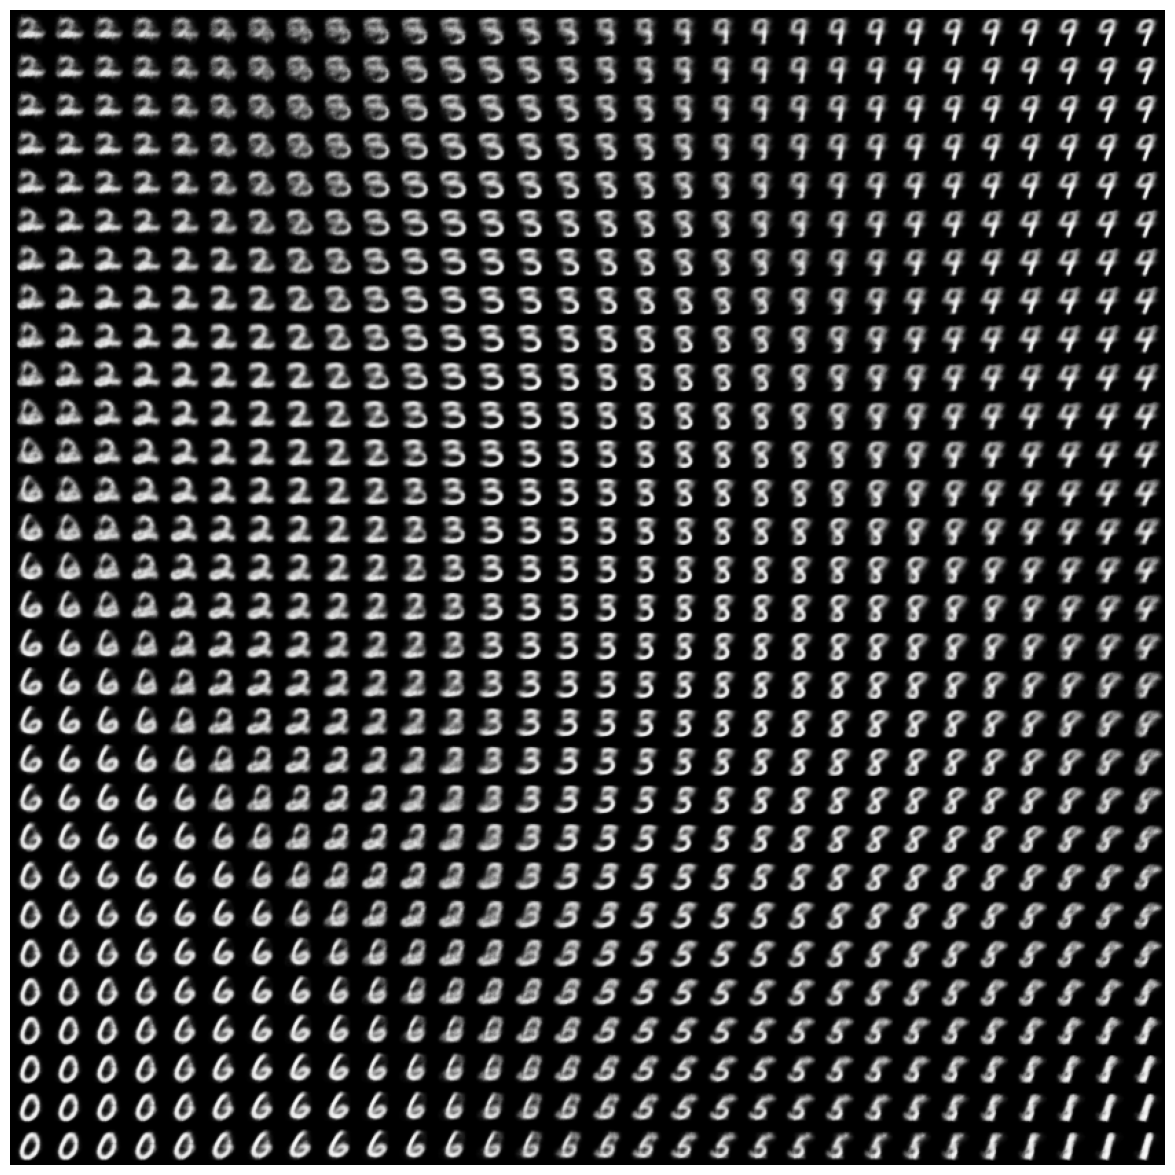

In [6]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We are going to make a 'grid' of values to sample from (means and variances for our latent distribution)
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

# For each pair of values...
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):

        # Turn the pair into an array
        z_sample = np.array([[xi, yi]])

        # Get the VAE decoder to spit out an image based on those mean and variance values.
        x_decoded = vae.decoder.predict(z_sample)

        # Reshape the result into a square image
        digit = x_decoded[0].reshape(digit_size, digit_size)

        # Stitch the new digit into our final output figure
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

# Finally, plot the resulting figure we just created (stitched together images from our VAE decoder)
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")